#### Bond Pricing Prediction

In this case study, we will use the data from the kaggle competion - https://www.kaggle.com/c/benchmark-bond-trade-price-challenge/rules .  As per the competion, we get Bond price data over the last 10 time points and a curve estimated price. Our goal is to compute the price at the corresponding time slice.

#### Python Imports

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

# Time series Models
from statsmodels.tsa.arima_model import ARIMA

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

C:\Users\sahil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Importing the data

For the purpose of this exercise we will use the training data file. We will evaluate our model performance based on the information in this file. The data can be freely downloaded from the Kaggle website.

In [25]:
df = pd.read_csv(r'.\benchmark-bond-trade-price-challenge\train.csv').dropna()

#### Predicting prices v/s returns

In prediction task, we can try to predict prices or we can try to predict returns. Bond prices are in general non-stationary. This means that at each time step, the price is strongly dependent on the price the previous time slice. A model trying to predict prices directly, would try to converge by using the previous time step.

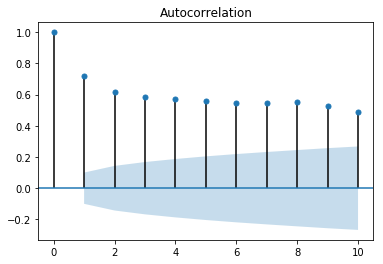

In [26]:
_ = plot_acf(df.loc[df['bond_id'] == 3, 'trade_price'].reset_index(drop=True), lags=10)

We can see from the Autocorrelation graph that we have statitically significant correlation in the prices. In order to get around this problem, we use **log returns** 

In [27]:
df['RetPrediction'] = np.log(df['trade_price']) - np.log(df['trade_price_last1'])
for i in range(9):
    df['Ret{}'.format(i+1)] = np.log(df['trade_price_last{}'.format(i+1)]) -\
                                    np.log(df['trade_price_last{}'.format(i+2)])

df['CurveRet'] = np.log(df['curve_based_price']) - np.log(df['trade_price_last1'])


We define returns for all preceeding time steps as well as the feature *curve return* which is what the return would be if the price matched the curve estimated price.

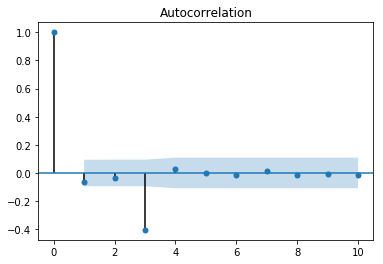

In [29]:
_ = plot_acf(df.loc[df['bond_id'] == 3, 'RetPrediction'].reset_index(drop=True), lags=10)

We can see that the returns are much closer to independently distributed variables as opposed to prices. Thus we will continue our prediction in the return space.

In [30]:
Y = df.loc[:, 'RetPrediction']
X = df.loc[:, ['Ret{}'.format(i+1) for i in range(9)] + ['CurveRet']]

In [31]:
dataset = pd.concat([Y, X], axis=1)

We begin by looking at the dataset.

In [32]:
pd.set_option('precision', 3)
dataset.describe()

,RetPrediction,Ret1,Ret2,Ret3,Ret4,Ret5,Ret6,Ret7,Ret8,Ret9,CurveRet
count,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,745009.000
mean,3.456e-05,3.684e-05,3.700e-05,3.437e-05,3.239e-05,2.999e-05,2.579e-05,2.351e-05,2.163e-05,2.253e-05,-0.002
std,1.535e-02,1.536e-02,1.536e-02,1.537e-02,1.538e-02,1.540e-02,1.541e-02,1.543e-02,1.545e-02,1.545e-02,0.017
min,-3.403e+00,-3.403e+00,-3.403e+00,-3.403e+00,-3.403e+00,-3.403e+00,-3.403e+00,-3.403e+00,-3.403e+00,-3.403e+00,-1.222
25%,-2.442e-03,-2.445e-03,-2.446e-03,-2.448e-03,-2.450e-03,-2.451e-03,-2.454e-03,-2.456e-03,-2.460e-03,-2.459e-03,-0.007
50%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-0.001
75%,2.520e-03,2.523e-03,2.525e-03,2.527e-03,2.529e-03,2.529e-03,2.530e-03,2.531e-03,2.535e-03,2.539e-03,0.002
max,3.425e+00,3.425e+00,3.425e+00,3.425e+00,3.425e+00,3.425e+00,3.425e+00,3.425e+00,3.425e+00,3.425e+00,3.426


We observe that there are some extremely large values are present in our dataset. In order to ensure that these do not skew the returns in our analysis, we clip all the extreme returns

In [33]:
dataset = dataset.clip(lower=dataset.quantile(0.005), upper=dataset.quantile(0.995), axis=1)

In [34]:
pd.set_option('precision', 3)
dataset.describe()

,RetPrediction,Ret1,Ret2,Ret3,Ret4,Ret5,Ret6,Ret7,Ret8,Ret9,CurveRet
count,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,7.450e+05,745009.000
mean,4.087e-05,4.326e-05,4.365e-05,4.173e-05,3.932e-05,3.718e-05,3.305e-05,3.095e-05,2.928e-05,3.008e-05,-0.002
std,1.017e-02,1.018e-02,1.018e-02,1.019e-02,1.021e-02,1.022e-02,1.023e-02,1.024e-02,1.026e-02,1.027e-02,0.012
min,-4.254e-02,-4.256e-02,-4.259e-02,-4.269e-02,-4.280e-02,-4.293e-02,-4.306e-02,-4.319e-02,-4.337e-02,-4.346e-02,-0.053
25%,-2.442e-03,-2.445e-03,-2.446e-03,-2.448e-03,-2.450e-03,-2.451e-03,-2.454e-03,-2.456e-03,-2.460e-03,-2.459e-03,-0.007
50%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-0.001
75%,2.520e-03,2.523e-03,2.525e-03,2.527e-03,2.529e-03,2.529e-03,2.530e-03,2.531e-03,2.535e-03,2.539e-03,0.002
max,4.149e-02,4.155e-02,4.162e-02,4.164e-02,4.166e-02,4.169e-02,4.172e-02,4.172e-02,4.181e-02,4.180e-02,0.050


As we can seefrom the min and the max values in the dataset that the values look a lot more resonable.

In [35]:
X = dataset.loc[:, X.columns]
Y = dataset.loc[:, Y.name]

Next we look at the distribution of our data using historgrams and density estimation plots.

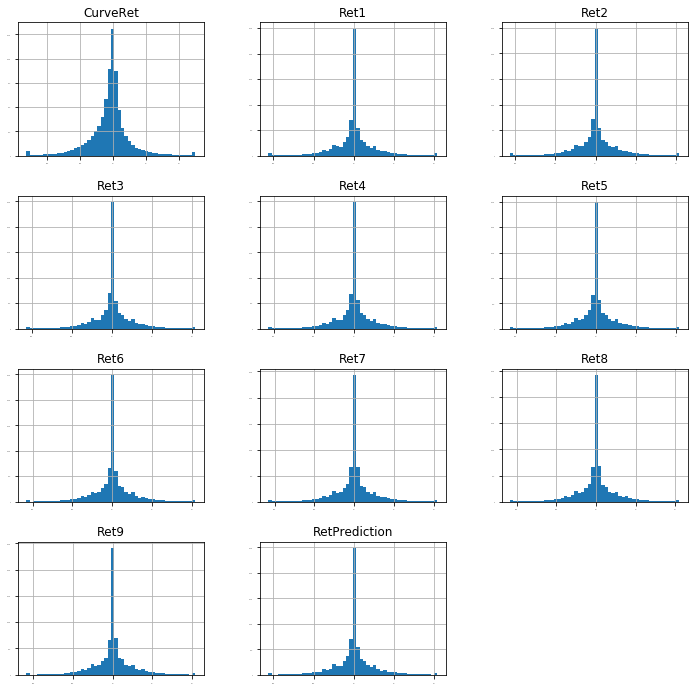

In [36]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

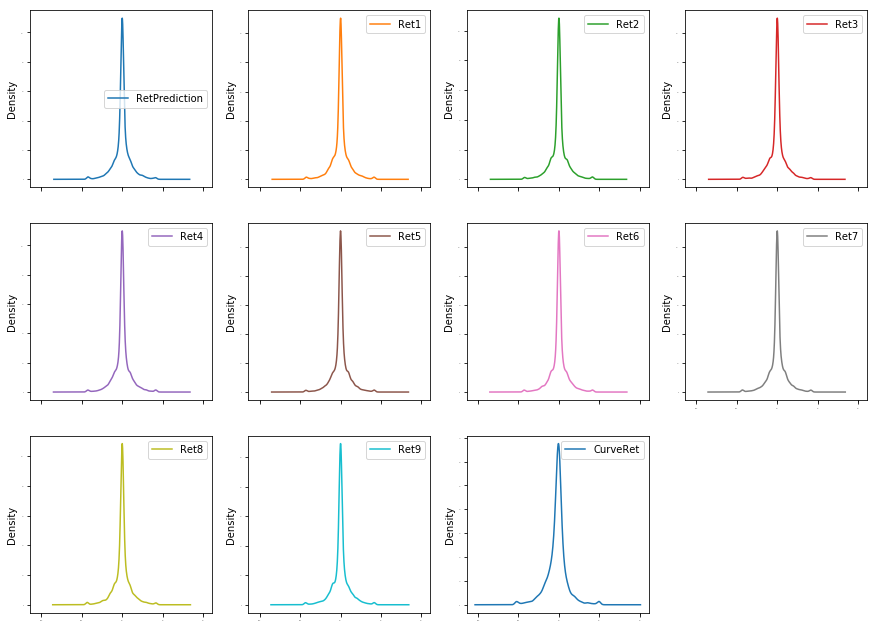

In [37]:
dataset.sample(10000).plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

The data looks slightly Leptokurtic in nature.

Next we look at the interations between the different variables. We do this by looking at the correlation matrix and the scatter plot matrix

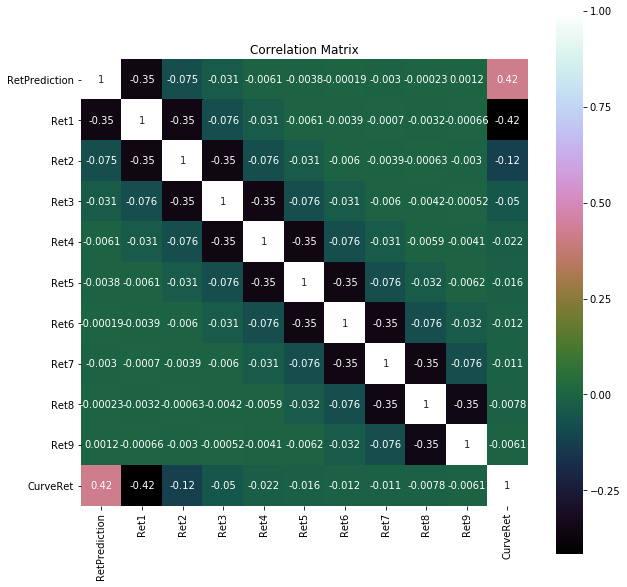

In [38]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

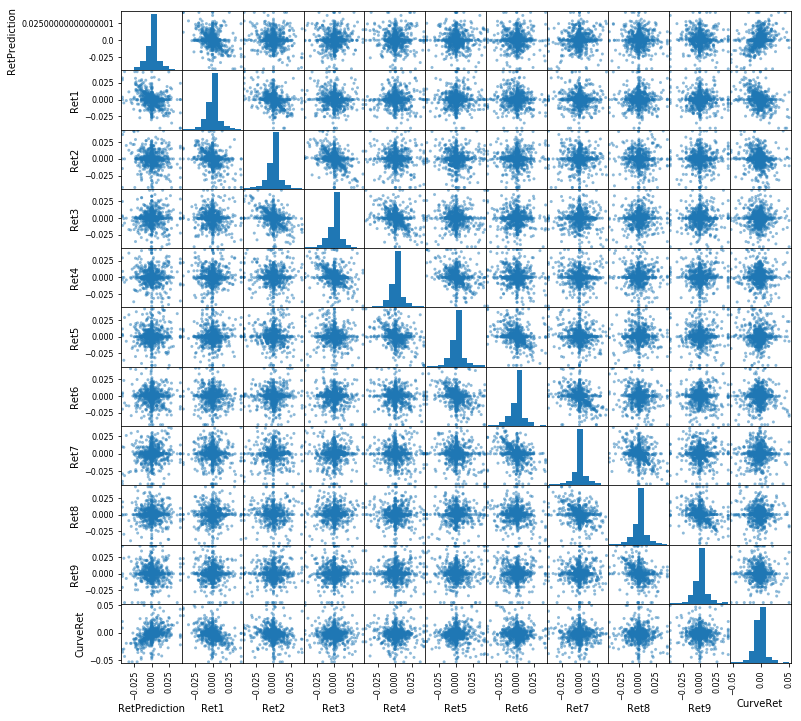

In [39]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset.sample(1000),figsize=(12,12))
pyplot.show()

From visual inspection, we can see that the prediction series seems to be dependent on the returns the previous day and the curve price based return.

We next test out each feature individually using a regression fit to test the importance.

In [40]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
CurveRet,161772.943
Ret1,105102.853
Ret2,4253.401
Ret3,702.921
Ret4,27.587
Ret5,11.031
Ret7,6.815
Ret9,1.124
Ret8,0.039


As we had previously guessed, the most important features are the curve return and the return one time step before. Beyond the returns after 5 days, we the the importance drop, thus we will shrink our set of features. (Note: Readers are encouraged to try to skip this step and see if there is any difference, we don't observe any major changes in the output)

In [41]:
X = X.loc[:, ['CurveRet', 'Ret1', 'Ret2', 'Ret3', 'Ret4', 'Ret5']]

### Train/Test Split

Next we bifurcate our data into training and testing samples.

In [42]:
validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [43]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

#### Linear Models and Regression Trees

In [44]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#### Neural Network Predictor

In [45]:
models.append(('MLP', MLPRegressor()))

#### Boosting and Bagging Methods

In [46]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [ ]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000080 (0.000013) 0.000080 0.000070
LASSO: 0.000105 (0.000017) 0.000105 0.000095
EN: 0.000105 (0.000017) 0.000105 0.000095


We being by looking at the Kfold analysis

In [ ]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We observe that the simple linear regression outperforms the other models. Next we look at the Full training sample error and the test error 

In [ ]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

We again find that the linear regression model does a better job forcasting in the test dataset

### Summary

In this case study we looked at how bond prices can be converted to a return space and used for prediction purposes. The non stationary nature of the prices causes them to be very sensative to the model paramters. 

In the return space we observe that thte returns we heavliy influcened by the curve prediction return and the previous time step return.

Out of all the models we tested, the linear regression models seems to outperform the others. We see that there is some overfitting in the decision tree regressor (CART) and the Extra Tress Regressor (ETR).